In [6]:
# Imports & Configuration (Updated for Folder Structure)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import warnings

# Scikit-learn & XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, precision_recall_curve, 
                             average_precision_score, roc_auc_score, 
                             f1_score, precision_score, recall_score)
import xgboost as xgb

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# --- 1. Suppress Warnings (Clean Output) ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. Configure Paths (Industry Standard) ---
# Set tracking URI to the PARENT directory (outside notebooks folder)
# "file:../mlruns" tells MLflow to create the folder one level up
mlflow.set_tracking_uri("file:../mlruns")

# Create a temporary folder for artifacts (images) if it doesn't exist
ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

# --- 3. Experiment Setup ---
EXPERIMENT_NAME = "fraud_detection_v1"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f" MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f" Artifacts Temp Folder: ./{ARTIFACT_PATH}/")
print(" Environment Ready.")

 MLflow Tracking URI: file:../mlruns
 Artifacts Temp Folder: ./temp_artifacts/
 Environment Ready.


In [7]:
# Load Pre-Processed Data
DATA_PATH = "../data/processed/"

# Load train and test (already split in Notebook 02)
train_df = pd.read_parquet(DATA_PATH + "train_processed.parquet")
test_df = pd.read_parquet(DATA_PATH + "test_processed.parquet")

# Quick validation
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")
print(f"Train Fraud Rate: {train_df['is_fraud'].mean()*100:.3f}%")
print(f"Test Fraud Rate:  {test_df['is_fraud'].mean()*100:.3f}%")
print(" Data loaded successfully.")

Train Shape: (227845, 54)
Test Shape:  (56962, 54)
Train Fraud Rate: 0.183%
Test Fraud Rate:  0.132%
 Data loaded successfully.


In [8]:
# Separate Features and Target

# Metadata columns - keep for analysis but exclude from training
METADATA_COLS = ['transaction_id', 'user_id', 'merchant_id', 'timestamp']

# Target column
TARGET = 'is_fraud'

# Feature columns = Everything except metadata and target
feature_cols = [col for col in train_df.columns if col not in METADATA_COLS + [TARGET]]

# Separate X and y
X_train = train_df[feature_cols]
y_train = train_df[TARGET]

X_test = test_df[feature_cols]
y_test = test_df[TARGET]

# Validation
print(f"Features: {len(feature_cols)} columns")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")
print(" Features and Target separated.")

Features: 49 columns
X_train: (227845, 49), y_train: (227845,)
X_test:  (56962, 49), y_test:  (56962,)
 Features and Target separated.


In [9]:
# Evaluation Helper Functions (Clean Version)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Calculate and return all evaluation metrics."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'pr_auc': average_precision_score(y_test, y_prob)
    }
    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix and return the Figure object.
    Does NOT save to disk automatically.
    """
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a new figure explicitly
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    plt.tight_layout()
    
    return fig  # Return the figure so we can save it later

print(" Evaluation functions updated (No auto-saving).")

 Evaluation functions updated (No auto-saving).


In [10]:
# Baseline Experiment (With Auto-Cleanup)
import shutil

# 1. Define Preprocessor (Same as before)
categorical_cols = ['card_tier', 'transaction_channel']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', RobustScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# 2. Setup Temp Directory
ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

run_name = "Baseline_LogReg_Balanced"

try:
    with mlflow.start_run(run_name=run_name):
        print(f" Starting Run: {run_name}")
        
        # --- Define & Train Pipeline ---
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
        ])
        pipeline.fit(X_train, y_train)
        
        # --- Evaluate ---
        metrics, y_pred, y_prob = evaluate_model(pipeline, X_test, y_test)
        
        # --- Log Metrics ---
        print("\n Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
            mlflow.log_metric(k, v)
            
        # --- Log Params ---
        mlflow.log_param("model_type", "Logistic Regression")
        
        # --- Handle Artifacts (The Clean Way) ---
        # 1. Get the figure object
        fig = plot_confusion_matrix(y_test, y_pred, model_name=run_name)
        
        # 2. Save to temp folder
        temp_file = f"{ARTIFACT_PATH}/confusion_matrix_{run_name}.png"
        fig.savefig(temp_file)
        plt.close(fig) # Free memory
        
        # 3. Upload to MLflow
        mlflow.log_artifact(temp_file)
        
        # --- Log Model ---
        input_example = X_train.iloc[:5]
        signature = infer_signature(input_example, pipeline.predict(input_example))
        mlflow.sklearn.log_model(
            sk_model=pipeline, 
            artifact_path="model",
            signature=signature, 
            input_example=input_example
        )
        print(f" Run Complete. Artifacts uploaded to MLflow.")

finally:
    # --- CLEANUP ---
    # This runs whether the code succeeds or fails
    if os.path.exists(ARTIFACT_PATH):
        shutil.rmtree(ARTIFACT_PATH)
        print(f" Cleaned up local folder: {ARTIFACT_PATH}/")

 Starting Run: Baseline_LogReg_Balanced

 Metrics:
  precision: 0.0610
  recall: 0.9467
  f1_score: 0.1146
  roc_auc: 0.9949
  pr_auc: 0.7958


2025/11/26 15:50:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 15:50:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


 Run Complete. Artifacts uploaded to MLflow.
 Cleaned up local folder: temp_artifacts/


In [11]:
# Challenger Experiment - XGBoost + SMOTE
# We use the same cleanup logic to keep the folder clean

# 1. Define the Preprocessor (Reuse existing one)
# preprocessor is already defined in Cell 5

# 2. Setup Temp Directory
ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

run_name = "Challenger_XGB_SMOTE"

try:
    with mlflow.start_run(run_name=run_name):
        print(f" Starting Run: {run_name}")
        
        # --- Define Pipeline ---
        # Step 1: Preprocess (Encode/Scale)
        # Step 2: SMOTE (Generate synthetic fraud cases to balance ratio)
        # Step 3: XGBoost (The powerful gradient boosting model)
        pipeline_xgb = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, sampling_strategy=0.1)), # Boost fraud to 10%
            ('classifier', xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='aucpr', # Optimize for Precision-Recall AUC
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        # --- Log Parameters ---
        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("smote_strategy", "0.1")
        mlflow.log_param("n_estimators", 100)
        
        # --- Train ---
        # Note: SMOTE happens automatically here, but ONLY on X_train
        pipeline_xgb.fit(X_train, y_train)
        
        # --- Evaluate ---
        metrics, y_pred, y_prob = evaluate_model(pipeline_xgb, X_test, y_test)
        
        # --- Log Metrics ---
        print("\n Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
            mlflow.log_metric(k, v)
            
        # --- Artifacts (Clean) ---
        fig = plot_confusion_matrix(y_test, y_pred, model_name=run_name)
        temp_file = f"{ARTIFACT_PATH}/confusion_matrix_{run_name}.png"
        fig.savefig(temp_file)
        plt.close(fig)
        mlflow.log_artifact(temp_file)
        
        # --- Log Model ---
        # Re-create example and signature for XGBoost specific inputs
        input_example = X_train.iloc[:5]
        signature = infer_signature(input_example, pipeline_xgb.predict(input_example))
        
        mlflow.sklearn.log_model(
            sk_model=pipeline_xgb, 
            artifact_path="model",
            signature=signature, 
            input_example=input_example
        )
        print(f" Run Complete. Check MLflow for comparison.")

finally:
    if os.path.exists(ARTIFACT_PATH):
        shutil.rmtree(ARTIFACT_PATH)

 Starting Run: Challenger_XGB_SMOTE

 Metrics:
  precision: 0.8906
  recall: 0.7600
  f1_score: 0.8201
  roc_auc: 0.9881
  pr_auc: 0.8203


2025/11/26 15:51:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 15:51:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


 Run Complete. Check MLflow for comparison.


In [12]:
# Optimization - XGBoost with Class Weights (No SMOTE)
# Industry View: Preferred for massive datasets where SMOTE is too slow/heavy.

ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

run_name = "XGB_ClassWeights_Optimized"

# Calculate the ratio for scale_pos_weight
# Formula: sum(negative) / sum(positive)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_weight = neg_count / pos_count

print(f" Calculated scale_pos_weight: {scale_weight:.2f}")

try:
    with mlflow.start_run(run_name=run_name):
        print(f" Starting Run: {run_name}")
        
        # --- Define Pipeline (NO SMOTE this time) ---
        # Just Preprocessor -> XGBoost
        pipeline_weighted = ImbPipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='aucpr',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                scale_pos_weight=scale_weight, # The magic parameter
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        # --- Log Params ---
        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("technique", "Class Weights")
        mlflow.log_param("scale_pos_weight", scale_weight)
        
        # --- Train ---
        pipeline_weighted.fit(X_train, y_train)
        
        # --- Evaluate ---
        metrics, y_pred, y_prob = evaluate_model(pipeline_weighted, X_test, y_test)
        
        print("\n Metrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")
            mlflow.log_metric(k, v)
            
        # --- Artifacts ---
        fig = plot_confusion_matrix(y_test, y_pred, model_name=run_name)
        temp_file = f"{ARTIFACT_PATH}/confusion_matrix_{run_name}.png"
        fig.savefig(temp_file)
        plt.close(fig)
        mlflow.log_artifact(temp_file)
        
        # --- Log Model ---
        input_example = X_train.iloc[:5]
        signature = infer_signature(input_example, pipeline_weighted.predict(input_example))
        mlflow.sklearn.log_model(
            sk_model=pipeline_weighted, 
            artifact_path="model",
            signature=signature, 
            input_example=input_example
        )
        print(f" Run Complete. Compare 'SMOTE' vs 'ClassWeights' in MLflow.")

finally:
    if os.path.exists(ARTIFACT_PATH):
        shutil.rmtree(ARTIFACT_PATH)

 Calculated scale_pos_weight: 545.39
 Starting Run: XGB_ClassWeights_Optimized

 Metrics:
  precision: 0.7778
  recall: 0.7467
  f1_score: 0.7619
  roc_auc: 0.9767
  pr_auc: 0.7804


2025/11/26 15:51:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/26 15:51:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


 Run Complete. Compare 'SMOTE' vs 'ClassWeights' in MLflow.


 Comparing Experiments...

 CHAMPION MODEL: Challenger_XGB_SMOTE
 Run ID: 1a865857537f4a30890f92685a739ebe
 PR-AUC Score: 0.8203


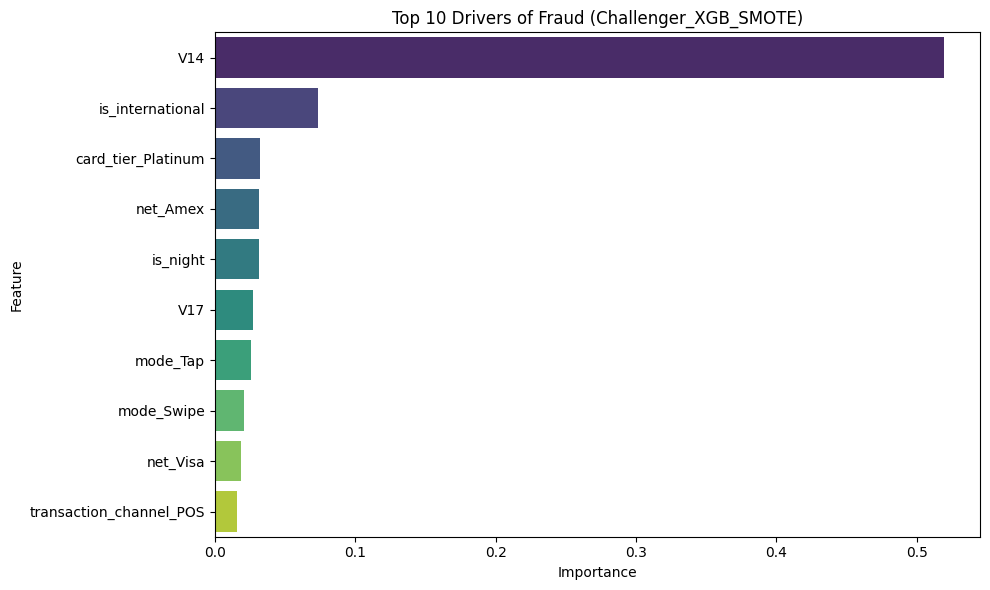

 Business Insight: These are the top patterns the model found.

 Ready for Deployment!
To deploy, use Run ID: 1a865857537f4a30890f92685a739ebe


In [13]:
# Final Model Selection & Feature Importance

# 1. Compare all runs programmatically
print(" Comparing Experiments...")
runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id])

# Sort by PR-AUC (Best metric for imbalance)
best_run = runs.sort_values("metrics.pr_auc", ascending=False).iloc[0]

best_run_id = best_run["run_id"]
best_model_name = best_run["tags.mlflow.runName"]
best_score = best_run["metrics.pr_auc"]

print(f"\n CHAMPION MODEL: {best_model_name}")
print(f" Run ID: {best_run_id}")
print(f" PR-AUC Score: {best_score:.4f}")

# 2. Load the Champion Model
# We load it back from MLflow to ensure we have the exact version that won
champion_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

# 3. Extract Feature Importance
# This is tricky because of the Pipeline structure
# Structure: Pipeline -> classifier (XGB)
if "XGB" in best_model_name:
    # Get the model step
    xgb_model = champion_model.named_steps['classifier']
    
    # Get feature names from the preprocessor
    preprocessor = champion_model.named_steps['preprocessor']
    
    # Get categorical feature names (OneHotEncoded)
    cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    
    # Get numerical feature names (RobustScaled)
    # RobustScaler doesn't change names, so we use the original list
    num_names = numerical_cols 
    
    # Combine
    all_feature_names = list(cat_names) + list(num_names)
    
    # Get importance scores
    importances = xgb_model.feature_importances_
    
    # Create DataFrame
    feat_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f"Top 10 Drivers of Fraud ({best_model_name})")
    plt.tight_layout()
    plt.show()
    
    print(" Business Insight: These are the top patterns the model found.")
else:
    print(" Champion is Logistic Regression. Coefficients can be extracted similarly if needed.")

# 4. Register the Model (Mock Production Handoff)
print("\n Ready for Deployment!")
print(f"To deploy, use Run ID: {best_run_id}")

In [ ]:
import shap
import matplotlib.pyplot as plt
import mlflow
import os

ARTIFACT_PATH = "temp_artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)

preprocessor = champion_model.named_steps['preprocessor']
classifier = champion_model.named_steps['classifier']

X_sample = X_test.sample(100, random_state=42)
X_sample_transformed = preprocessor.transform(X_sample)

print(f" Explaining Model Logic: {best_model_name}")

# Get feature names
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_names = list(cat_names) + list(numerical_cols)

# Use TreeExplainer for tree-based models (much faster)
if any(model in best_model_name.upper() for model in ['RANDOMFOREST', 'XGB']):
    print(" Using TreeExplainer (Fast)")
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_sample_transformed)
    
    # For binary classification, take the positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # Create summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample_transformed, 
                      feature_names=all_names, 
                      show=False)
    
    # Save
    temp_file = f"{ARTIFACT_PATH}/shap_summary_{best_run_id}.png"
    plt.savefig(temp_file, bbox_inches='tight', dpi=150)
    plt.close()
    
    print(f" File saved: {os.path.abspath(temp_file)}")
    
    with mlflow.start_run(run_id=best_run_id):
        mlflow.log_artifact(temp_file)
    
    print(" SHAP Summary logged to MLflow.")
    
else:
    print(" Using LinearExplainer or KernelExplainer for non-tree models")
    # Use appropriate explainer based on model type

 Explaining Model Logic: Challenger_XGB_SMOTE
 Using TreeExplainer (Fast)
 File saved: c:\Users\Home\realtime-fraud-detection-mlops\notebooks\temp_artifacts\shap_summary_1a865857537f4a30890f92685a739ebe.png
 SHAP Summary logged to MLflow.
